# Application of Compressed Gene Expression Signatures

**Gregory Way, 2018**

We previously identified a specific VAE feature (z = 3) that captured blood signatures.
These signatures were not captured in VAE z = 2, and, when present, contributed to a rapid increase in the ability to capture the signal in GTEX blood tissues.

The primary differences between the two VAE models appeared to be related to neutrophil and monocyte signatures. Here, we test the ability of these signatures to generalize to external datasets.


## Part 1:

### Enrichment of Neutrophil Signatures

Here, we apply the VAE feature enriched for neutrophil genes to a publicly available dataset capturing neutrophil differentiation in two leukemia cell lines.

![cell_type_Neutrophils_HPCA_2.png](https://github.com/greenelab/BioBombe/raw/master/6.analyze-weights/figures/GTEX/signal/GpXCELL/gene_set_Neutrophils_HPCA_2.png)

## Part 2:

### Enrichment of Monocyte Signatures

Here, we apply the VAE features enriched for monocyte genes to a different publicly available dataset that captures various cell-types undergoing hematopoiesis.

![cell_type_Monocytes_FANTOM_2.png](https://github.com/greenelab/BioBombe/raw/master/6.analyze-weights/figures/GTEX/signal/GpXCELL/gene_set_Monocytes_FANTOM_2.png)

## Output

In both cases, various scores are output that will be visualized in a separate notebook.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hetio.readwrite
import hetmech.matrix

from scripts.utils import load_weight_matrix, apply_signature, load_enrichment_results

sys.path.append('../scripts')
from latent import parse_gmt

In [2]:
%matplotlib inline

In [3]:
np.random.seed(123)

## 1.0. Load and Process External Neutrophil Dataset

In [4]:
file = os.path.join('data', 'GSE103706_processed_matrix.tsv.gz')
geo_scaled_zeroone_df = pd.read_table(file, index_col=0)

print(geo_scaled_zeroone_df.shape)
geo_scaled_zeroone_df.head(2)

(14, 19272)


,7105,64102,8813,6359,55732,2268,3075,2519,2729,4800,...,79447,140032,101234261,100996720,100527949,100862671,100861540,140,100033411,100129520
"PLB-985, not differentiated, replicate 1",0.0,0.0,0.634427,0.166941,1.000000,0.000000,0.0,0.01219,0.358691,0.40302,...,1.000000,0.0,0.0,0.173369,0.020122,0.025108,0.0,0.000093,0.0,0.0
"PLB-985, DMSO, day 6, replicate 1",0.0,0.0,0.294013,0.876342,0.041159,0.089441,0.0,0.00000,0.954808,0.65640,...,0.495317,0.0,0.0,1.000000,0.017264,0.499439,0.0,0.352886,0.0,0.0


## 1.1. Apply Signature from VAE z = 3 (feature 0)

In [5]:
vae_z3_seed = 908341
vae_z3_feature = 'vae_0'

In [6]:
weight_z3_df = load_weight_matrix(dataset='GTEX',
                                  z_dim=3,
                                  seed=vae_z3_seed)

result_vae_3_feat0 = apply_signature(weight_df=weight_z3_df,
                                     other_df=geo_scaled_zeroone_df,
                                     feature=vae_z3_feature,
                                     align=True)

## 1.2. Apply Signature from VAE z = 14 (feature 10)

In [7]:
vae_z14_seed = 486191
vae_z14_feature = 'vae_10'

In [8]:
weight_z14_df = load_weight_matrix(dataset='GTEX',
                                   z_dim=14,
                                   seed=vae_z14_seed)

result_vae_14_feat10 = apply_signature(weight_df=weight_z14_df,
                                       other_df=geo_scaled_zeroone_df,
                                       feature=vae_z14_feature,
                                       align=True)

## 1.3. Combine Data and Add Phenotype Information

In [9]:
full_neutrophil_results_df = result_vae_14_feat10.merge(result_vae_3_feat0,
                                                        left_index=True,
                                                        right_index=True)

In [10]:
# Process phenotype data
cell_line = [x[0] for x in result_vae_3_feat0.index.str.split(',')]
treatment = [x[1] for x in result_vae_3_feat0.index.str.split(',')]
day = [x[2].strip(' ') if 'replicate' not in x[2] else 'day 0'
       for x in result_vae_3_feat0.index.str.split(',')]

In [11]:
full_neutrophil_results_df = (
    full_neutrophil_results_df
    .assign(cell_line=cell_line,
            treatment=treatment,
            day=day)
    .reset_index()
    .rename(columns={'index': 'full_id'})
)

recode_labels = {' not differentiated': 'Not Differentiated',
                 ' DMSO': 'DMSO',
                 ' DMSO+Nutridoma': 'DMSO+Nutridoma'}

full_neutrophil_results_df.treatment = full_neutrophil_results_df.treatment.replace(recode_labels)

file = os.path.join('results', 'neutrophil_data_biobombe_results.tsv')
full_neutrophil_results_df.to_csv(file, index=False, sep='\t')

full_neutrophil_results_df

,full_id,vae_10,vae_0,cell_line,treatment,day
0,"PLB-985, not differentiated, replicate 1",15.023124,-197.212255,PLB-985,Not Differentiated,day 0
1,"PLB-985, DMSO, day 6, replicate 1",-30.062771,-165.257834,PLB-985,DMSO,day 6
2,"PLB-985, DMSO+Nutridoma, day 4",-28.914972,-162.056202,PLB-985,DMSO+Nutridoma,day 4
3,"PLB-985, DMSO+Nutridoma, day 6, replicate 1",-35.947254,-153.059585,PLB-985,DMSO+Nutridoma,day 6
4,"HL-60, not differentiated, replicate 1",3.711192,-165.541292,HL-60,Not Differentiated,day 0
5,"HL-60, DMSO, day 6, replicate 1",-36.608932,-156.390062,HL-60,DMSO,day 6
6,"HL-60, DMSO+Nutridoma, day 6, replicate 1",-36.797638,-144.121119,HL-60,DMSO+Nutridoma,day 6
7,"PLB-985, not differentiated, replicate 2",9.900077,-145.737554,PLB-985,Not Differentiated,day 0
8,"PLB-985, DMSO, day 6, replicate 2",-31.274222,-116.195076,PLB-985,DMSO,day 6
9,"PLB-985, DMSO+Nutridoma, day 2",-16.068799,-136.136777,PLB-985,DMSO+Nutridoma,day 2


## 1.4. Quickly Visualize Signature Applied to External Dataset

Note the final figure is compiled in an alternative notebook

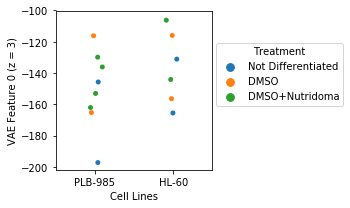

In [12]:
# Quickly visualize results
plt.rcParams['figure.figsize'] = 5, 3
ax = sns.stripplot(x='cell_line',
                   y='vae_0',
                   data=full_neutrophil_results_df,
                   hue='treatment',
                   jitter=0.1)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles,
               labels,
               bbox_to_anchor=(1.02, 0.8),
               loc=2,
               borderaxespad=0.)
l.set_title("Treatment")

ax.set_ylabel('VAE Feature 0 (z = 3)')
ax.set_xlabel('Cell Lines')

plt.tight_layout()

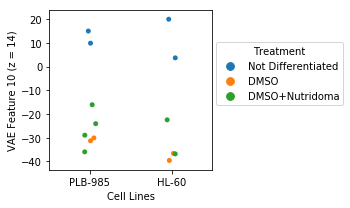

In [13]:
# Quickly visualize results
plt.rcParams['figure.figsize'] = 5, 3
ax = sns.stripplot(x='cell_line',
                   y='vae_10',
                   data=full_neutrophil_results_df,
                   hue='treatment',
                   jitter=0.1)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles,
               labels,
               bbox_to_anchor=(1.02, 0.8),
               loc=2,
               borderaxespad=0.)
l.set_title("Treatment")

ax.set_ylabel('VAE Feature 10 (z = 14)')
ax.set_xlabel('Cell Lines')

plt.tight_layout()

## 1.5. Compare the two signatures derived from both models

In [14]:
# What other genesets are enriched in VAE z = 3 feature?
vae_z3_p0 = load_enrichment_results(dataset='GTEX',
                                    z_dim=3,
                                    metaedge='GpXCELL',
                                    algorithm='vae',
                                    feature=0,
                                    seed=vae_z3_seed,
                                    shuffled=False)

# What other genesets are enriched in VAE z = 14 feature?
vae_z14_p10 = load_enrichment_results(dataset='GTEX',
                                      z_dim=14,
                                      metaedge='GpXCELL',
                                      algorithm='vae',
                                      feature=10,
                                      seed=vae_z14_seed,
                                      shuffled=False)

full_test_df = vae_z3_p0.merge(vae_z14_p10, on='variable', suffixes=('_z3', '_z14'))

file = os.path.join('results', 'latent_feature_enrichment_comparison_neutrophil_genesets.tsv')
full_test_df.to_csv(file, index=False, sep='\t')

full_test_df.head(3)

,model_type_z3,variable,value_z3,z_score_z3,algorithm_z3,feature_z3,z_z3,seed_z3,model_type_z14,value_z14,z_score_z14,algorithm_z14,feature_z14,z_z14,seed_z14
0,real,Keratinocytes_HPCA_3,-10.9015,-33.32250,vae,2,3,908341,real,-2.46113,-5.42071,vae,10,14,486191
1,real,Keratinocytes_HPCA_3,-11.9194,-19.00490,vae,1,3,908341,real,-2.46113,-5.42071,vae,10,14,486191
2,real,Keratinocytes_HPCA_3,1.3954,5.91483,vae,0,3,908341,real,-2.46113,-5.42071,vae,10,14,486191


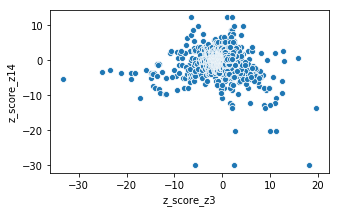

In [15]:
# Save dataframe for better plotting in R, but visualize quickly here
sns.scatterplot(data=full_test_df, x='z_score_z3', y='z_score_z14');

### 1.5.1 Determine Gene Weights across the Two Features

Also assign labels to which genesets the genes contribute to

In [16]:
# First, load the XCELL dataset and extract genes that belong to neutrophil processes
geneset_file = os.path.join('..', '3.build-hetnets', 'data', 'xcell_all_entrez.gmt')

xcell_genesets_gmt = parse_gmt(gene_sets=[geneset_file])
len(xcell_genesets_gmt)

489

In [17]:
unique_genes = []
for geneset_name, geneset in xcell_genesets_gmt.items():
    for gene in geneset:
        unique_genes.append(gene)

unique_genes = set(unique_genes)

classification_genes = []
for geneset_name, geneset in xcell_genesets_gmt.items():
    if 'neutrophil' in geneset_name.lower():
        classification = 'Neutrophils'
    elif 'keratinocytes' in geneset_name.lower():
        classification = 'Keratinocytes'
    elif 'neurons' in geneset_name.lower():
        classification = 'Neurons'
    elif 'skeletal' in geneset_name.lower():
        classification = 'Skeletal Muscle'
    elif 'monocytes' in geneset_name.lower():
        classification = 'Monocytes'
    else:
        classification = 'Other Geneset'
    for gene in geneset:
        if gene in weight_z14_df.index:
            classification_genes.append([classification, gene, geneset_name])

In [18]:
result_df = (
    pd.DataFrame(classification_genes, columns=['classification', 'gene', 'gene_set'])
    .sort_values(by='classification')
    .reset_index(drop=True)
    .drop_duplicates(subset='gene', keep='first')
)

result_df.gene = result_df.gene.astype(str)
result_df.index = result_df.gene
result_df.head()

,classification,gene,gene_set
gene,,,
5228,Keratinocytes,5228,Keratinocytes_FANTOM_1
6273,Keratinocytes,6273,Keratinocytes_FANTOM_2
6279,Keratinocytes,6279,Keratinocytes_FANTOM_2
6280,Keratinocytes,6280,Keratinocytes_FANTOM_2
6665,Keratinocytes,6665,Keratinocytes_FANTOM_2


In [19]:
result_df.classification.value_counts()

Other Geneset      2250
Monocytes           202
Neurons             169
Keratinocytes        90
Neutrophils          27
Skeletal Muscle      13
Name: classification, dtype: int64

In [20]:
both_weight_df = (
    weight_z3_df.merge(weight_z14_df,
                       left_index=True,
                       right_index=True,
                       suffixes=('_3', '_14'))
    .merge(result_df, left_index=True,
           right_index=True, how='left')
    .fillna('No Geneset')
)

file = os.path.join('results', 'latent_feature_enrichment_comparison_neutrophil_genes.tsv')
both_weight_df.to_csv(file, index=False, sep='\t')

## 2.0. Load and Process External Hematopoietic Dataset

In [21]:
file = os.path.join('data', 'GSE24759_processed_matrix.tsv.gz')
heme_zeroone_df = pd.read_table(file, index_col=0)

print(heme_zeroone_df.shape)
heme_zeroone_df.head(2)

(211, 8968)


,8563,8434,55099,4863,4628,1387,55854,79572,1785,2634,...,9125,2885,26276,3106,64757,9764,57819,192683,152559,2669
HSC1_1,0.312585,0.765356,0.294345,0.625128,0.608219,0.766648,0.621663,0.725602,0.670308,0.696596,...,0.291599,0.178822,0.598740,0.552248,0.295143,0.153165,0.963897,0.176392,0.923904,0.336856
HSC1_13,0.311769,0.561833,0.329615,0.401469,0.487599,0.637845,0.644225,0.713899,0.459758,0.667098,...,0.287931,0.248829,0.743992,0.565033,0.473721,0.156976,0.964679,0.307535,0.810295,0.314071


In [22]:
heme_z3_seed = 908341
heme_z3_feature = 'vae_2'

In [23]:
# Transform the external dataset with this learned feature
weight_heme_z3_df = load_weight_matrix(dataset='GTEX',
                                       z_dim=3,
                                       seed=heme_z3_seed)

result_heme_vae_3_feat2 = apply_signature(weight_df=weight_heme_z3_df,
                                          other_df=heme_zeroone_df,
                                          feature=heme_z3_feature,
                                          align=True)

In [24]:
# Additionall, the top scoring feature for Monocytes_FANTOM_2 is in the nmf model with 200 features
file = os.path.join('..', '6.analyze-weights', 'results', 'gtex',
                    'gpxcell', 'signal',
                    'gtex_z_200_GpXCELL__geneset_scores.tsv.gz')

gtex_z200_scores_df = (
    pd.read_table(file)
    .query('variable == "Monocytes_FANTOM_2"'))

gtex_z200_scores_df = (
    gtex_z200_scores_df
    .assign(abs_z_score = gtex_z200_scores_df.z_score.abs())
    .sort_values(by='abs_z_score', ascending=False)
    .head(1)
)

gtex_z200_scores_df

,model_type,variable,value,z_score,algorithm,feature,z,seed,abs_z_score
2444895,real,Monocytes_FANTOM_2,37.7563,31.9881,nmf,6,200,908341,31.9881


In [25]:
heme_z200_feature = '{}_{}'.format(gtex_z200_scores_df.algorithm.values[0],
                                   gtex_z200_scores_df.feature.values[0])

heme_z200_feature

'nmf_6'

In [26]:
# Obtain this transformation too
weight_heme_z200_df = load_weight_matrix(dataset='GTEX',
                                         z_dim=200,
                                         seed=gtex_z200_scores_df.seed.values[0])


result_heme_nmf_200_feat6 = apply_signature(weight_df=weight_heme_z200_df,
                                            other_df=heme_zeroone_df,
                                            feature=heme_z200_feature,
                                            align=True)

In [27]:
# Combine the full scores and output for downstream visualization
full_heme_result_df = (
    result_heme_vae_3_feat2
    .merge(result_heme_nmf_200_feat6, left_index=True, right_index=True)
    .reset_index().rename(columns={'index': 'cell'})
)

In [28]:
heme_cell_type_recode_df = (
    pd.DataFrame(full_heme_result_df.cell.str.split('_').values.tolist(),
                 columns = ['cell_type', 'replicate', 'additional'])
)

heme_cell_type_recode_df.loc[~heme_cell_type_recode_df.additional.isna(), 'cell_type'] = "PRE_BCELL2"

In [29]:
full_heme_result_df = (
    pd.concat([heme_cell_type_recode_df.drop(['additional'], axis='columns'),
               full_heme_result_df], axis='columns')
)

In [30]:
# Recode cell-type into larger classification
file = os.path.join('results', 'cell-type-classification.tsv')
cell_class_df = pd.read_table(file)

cell_updater = dict(zip(cell_class_df.label, cell_class_df.classification))

cell_class_df.head()

,label,classification
0,HSC1,HSC
1,HSC2,HSC
2,HSC3,HSC
3,CMP,Myeloid
4,MEP,Myeloid


In [31]:
full_heme_result_df = (
    full_heme_result_df
    .assign(cell_class = full_heme_result_df.cell_type.replace(cell_updater))
)

file = os.path.join('results', 'hematopoietic_data_biobombe_results.tsv')
full_heme_result_df.to_csv(file, index=False, sep='\t')

full_heme_result_df.head()

,cell_type,replicate,cell,vae_2,nmf_6,cell_class
0,HSC1,1,HSC1_1,16.635073,279.152254,HSC
1,HSC1,13,HSC1_13,16.515089,287.086240,HSC
2,HSC1,14,HSC1_14,16.751959,269.305807,HSC
3,HSC1,2,HSC1_2,17.084755,265.566778,HSC
4,HSC1,3,HSC1_3,14.739639,251.125044,HSC


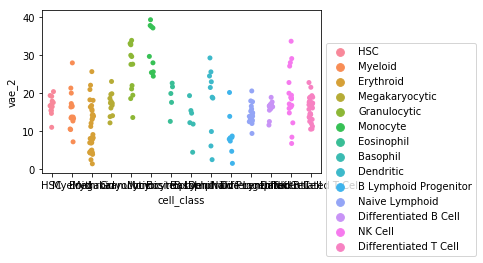

In [32]:
# Quickly plot results for both features
plt.rcParams['figure.figsize'] = 5, 3
ax = sns.stripplot(y='vae_2', x = 'cell_class', data = full_heme_result_df, hue = 'cell_class', jitter=0.1)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles,
               labels,
               bbox_to_anchor=(1.02, 0.8), loc=2, borderaxespad=0.)


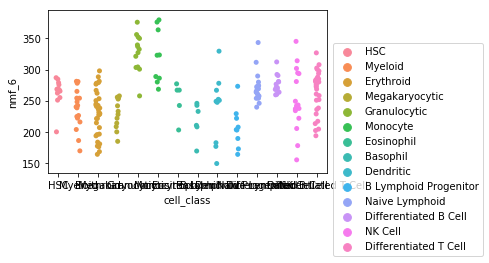

In [33]:
plt.rcParams['figure.figsize'] = 5, 3
ax = sns.stripplot(y='nmf_6', x = 'cell_class', data = full_heme_result_df, hue = 'cell_class', jitter=0.1)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles,
               labels,
               bbox_to_anchor=(1.02, 0.8), loc=2, borderaxespad=0.)